Test brouillon Clo

The `solve_steady_state` method return a `SteadyStateDict` object. 

`ss`stores variables in 2 levels: top and internal:
- top level = scalars, which are accessible for all blocks of the model 
- the internal level = block-specific multidimnesion variables

## Main replication file

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json

import sequence_jacobian as sj # sequence-space Jacobian toolkit

from household import hh_ha, hh_ta, hh_ra

In [87]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})
# plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

In [88]:
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y               # production technology (to first order, i.e. ignoring any Calvo or Rotemberg distortion)
    wN = Y / mu
    div = Y - wN
    return N, wN, div

In [89]:
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.simple
def nom_ST_bonds(r_ante, pi):
    """Bond returns if bonds are short term and nominal"""
    # real return adjusted downward by any excess of expected over actual inflation
    pi_e = pi(1)
    r_post_bonds = (1 + r_ante(-1)) * (1 + pi_e(-1))/(1 + pi) - 1
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.solved(unknowns={'qbond': (0.001, 100.)}, targets=['q_res'], solver="brentq")
def real_LT_bonds(qbond, r_ante, delta):
    """Bond returns if bonds are long term and real"""
    # equation for end-of-period price q of stream of future coupons (1,delta,delta^2,...): q_res=0
    q_res = qbond - (1 + delta * qbond(+1)) / (1 + r_ante)

    # ex-post return on bonds is coupon today plus delta times value of remaining coupon stream
    # divided by yesterday's end-of-period price
    r_post_bonds = (1 + delta * qbond) / qbond(-1) - 1
    return r_post_bonds, q_res

In [90]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

In [91]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

In [92]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

In [93]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

In [94]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

In [95]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

In [96]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

In [97]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

1.1142857142857143

In [98]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

In [99]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

In [100]:
ss = {}

In [101]:
with open('hh_params.json') as f:
    ha_params = json.load(f)

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']

(2.0236257114447653e-11, 5.881724645107056e-07, -2.220446049250313e-18)

In [102]:
print(ss)

{'ha': <SteadyStateDict: ['Y', 'mu', 'r_ante', 'B', 'G', 'tax_rate_shock', 'T_shock', 'T_rule_coeff', 'pi', 'kappa', 'beta_ave', 'vscale', 'frisch', 'eis', 'min_a', 'max_a', 'n_a', 'beta_hi', 'dbeta', 'omega', 'q', 'Tr_lumpsum', 'Tax_richest', 'zeta', 'r_post_bonds', 'qbond', 'N', 'wN', 'div', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'p', 'r_post_equity', 'cap_cond', 'r', 'A', 'C', 'asset_mkt', 'goods_mkt', 'nkpc_res'], internals=['hh_ha']>}


In [103]:
print(f'Micro outputs: {hh_ha.internals}')
# there is the consumption variable 'c' in the dictionnary

Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c', 'e_grid', 'a_grid', 'beta', 'pi_pdf', 'y']


Micro outputs:
- `D`
- `Dbeg`
- `Pi`
- `Va`
- `a`
- `c`
- `e_grid`
- `a_grid`
- `beta`
- `pi_pdf`
- `y`

In [104]:
partial_eq = hh_ha.steady_state({**ha_params, **common_params})

In [105]:
partial_eq.internals['hh_ha']['c'].min() 
# minimum de consumption is 0.003722594


0.003722594280479629

In [106]:
global_eq =  hh_ha.steady_state({**ha_params, **common_params})
#global_eq.outputs['hh_ha']['c'].min() 

In [107]:
print(ss['ha']['C'])

0.8000005881724646


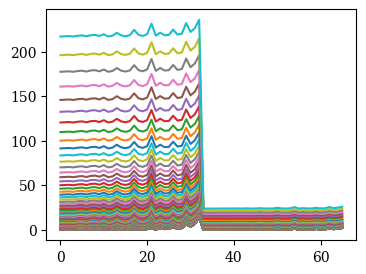

In [108]:
trunc = 275
plt.plot(partial_eq.internals['hh_ha']['c'][:trunc])

In [109]:
print(partial_eq.internals['hh_ha']['c']) # we have all beta-income states thus 66 rows 
print(partial_eq.internals['hh_ha']['c'].shape)
# shape(66,200)
c_ss = partial_eq.internals['hh_ha']['c']

[[3.72259428e-03 1.15343342e-02 1.74260891e-02 ... 1.77284595e+02
  1.95940290e+02 2.16844918e+02]
 [8.60009640e-03 1.92159874e-02 2.61499403e-02 ... 1.77501766e+02
  1.96157297e+02 2.17061757e+02]
 [1.77969770e-02 2.91833363e-02 3.94571307e-02 ... 1.77788184e+02
  1.96443558e+02 2.17347853e+02]
 ...
 [8.49723765e-01 8.49826507e-01 8.49931591e-01 ... 2.00151801e+01
  2.20534188e+01 2.43378132e+01]
 [1.28636041e+00 1.28645158e+00 1.28654482e+00 ... 2.04884479e+01
  2.25273795e+01 2.48124537e+01]
 [2.18601461e+00 2.18610084e+00 2.18618904e+00 ... 2.15476527e+01
  2.35898784e+01 2.58782987e+01]]
(66, 200)


In [110]:
print(partial_eq.internals['hh_ha']['Dbeg']) # we have all beta-income states thus 66 rows 
print(partial_eq.internals['hh_ha']['Dbeg'].shape)
# shape(66,200)
D_ss = partial_eq.internals['hh_ha']['Dbeg']

[[9.56951919e-05 5.11270815e-06 2.51387065e-06 ... 1.30398110e-15
  2.76500882e-16 4.62625885e-17]
 [2.83996384e-04 8.85267768e-06 5.05242332e-06 ... 3.15521539e-15
  6.67643258e-16 1.10477996e-16]
 [6.15950775e-04 1.34268782e-05 8.14296581e-06 ... 5.71876573e-15
  1.20756095e-15 1.97862989e-16]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.65460085e-12
  9.78486494e-13 2.56958980e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.45186932e-12
  1.35710202e-12 3.83201661e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.01863442e-12
  1.93625307e-12 5.84876683e-13]]
(66, 200)


In [111]:

#c_ss = partial_eq.internals['hh_ha']['c']
print(partial_eq.internals['hh_ha']['c'].sum(axis=0))
print(partial_eq.internals['hh_ha']['c'].sum(axis=0).shape)

[  60.29449502   60.63516624   60.95779717   61.27070123   61.57422571
   61.86864419   62.15437224   62.435442     62.70777145   62.98004991
   63.24888874   63.50939729   63.76855223   64.02765051   64.28560993
   64.54329452   64.7986562    65.05236365   65.30812867   65.56373154
   65.8196603    66.07654844   66.33454185   66.5943944    66.85564688
   67.11737847   67.37973645   67.64360638   67.90940714   68.17446237
   68.44119439   68.71029396   68.98146602   69.25500465   69.53053315
   69.80906939   70.09133533   70.37739725   70.66635632   70.9586085
   71.2547285    71.55261352   71.85274256   72.15668942   72.46278712
   72.77326224   73.08774092   73.40637983   73.72914291   74.05618645
   74.38819491   74.72575313   75.06911579   75.41807755   75.77303648
   76.13447902   76.50223269   76.87638095   77.25803736   77.64686221
   78.04267903   78.44648179   78.85842455   79.27854672   79.70717716
   80.14482639   80.59185039   81.04918551   81.51759966   81.99744967
   82.4

In [112]:
#print(partial_eq.internals['hh_ha']['e_grid'])
print(partial_eq.internals['hh_ha']['e_grid'].shape) # productivity grid 
# shape(66,)
# D = ss.internals['hh_ha']['D'].sum(axis=0) # distribution over asset grid alone

(66,)


In [113]:
y_ss =partial_eq.internals['hh_ha']['y']
print(partial_eq.internals['hh_ha']['y'])
print(partial_eq.internals['hh_ha']['y'].shape) # total income per person 
# shape(66,)
print(partial_eq.internals['hh_ha']['y'].sum(axis=0))
# total income at ss 228.33073118410147

[3.72259428e-03 8.60009640e-03 1.77969770e-02 2.47033364e-02
 3.24915031e-02 5.10041046e-02 5.70707036e-02 6.42911774e-02
 8.10396639e-02 1.18101699e-01 1.27213428e-01 1.63932665e-01
 2.15615363e-01 2.32250440e-01 3.38465982e-01 3.78724267e-01
 4.26639721e-01 4.80617345e-01 5.37783591e-01 7.83729200e-01
 8.44195187e-01 1.11034279e+00 1.43083521e+00 1.54122635e+00
 2.24607856e+00 2.83120420e+00 3.18940262e+00 3.56876085e+00
 5.60212468e+00 7.36829424e+00 1.02276612e+01 2.11650478e+01
 4.88963980e+01 3.72259428e-03 8.60009640e-03 1.77969770e-02
 2.47033364e-02 3.24915031e-02 5.10041046e-02 5.70707036e-02
 6.42911774e-02 8.10396639e-02 1.18101699e-01 1.27213428e-01
 1.63932665e-01 2.15615363e-01 2.32250440e-01 3.38465982e-01
 3.78724267e-01 4.26639721e-01 4.80617345e-01 5.37783591e-01
 7.83729200e-01 8.44195187e-01 1.11034279e+00 1.43083521e+00
 1.54122635e+00 2.24607856e+00 2.83120420e+00 3.18940262e+00
 3.56876085e+00 5.60212468e+00 7.36829424e+00 1.02276612e+01
 2.11650478e+01 4.889639

In [114]:
print(partial_eq.internals['hh_ha']['beta'])
print(partial_eq.internals['hh_ha']['beta'].shape) # beta grid 
# shape(66,)
# de 0 à 32 obs -> 0.91, de 33 a 67 -> 0.98

[0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272 0.91090272
 0.91090272 0.91090272 0.91090272 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287
 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287 0.99876287]
(66,)


In [115]:
pi_pdf_ss = partial_eq.internals['hh_ha']['pi_pdf']
print(partial_eq.internals['hh_ha']['pi_pdf'].shape) # stationary distribution over all joint (β,e)(β,e)-states.
# shape(66,)
# de 0 à 32 obs -> 0.91, de 33 a 67 -> 0.98
print(partial_eq.internals['hh_ha']['pi_pdf'].sum(axis=0))

(66,)
1.0000000000000981


In [116]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['pi_pdf']
print(partial_eq.internals['hh_ha']['Dbeg'])
print(partial_eq.internals['hh_ha']['Dbeg'].shape)
#shape (66,200)

[[9.56951919e-05 5.11270815e-06 2.51387065e-06 ... 1.30398110e-15
  2.76500882e-16 4.62625885e-17]
 [2.83996384e-04 8.85267768e-06 5.05242332e-06 ... 3.15521539e-15
  6.67643258e-16 1.10477996e-16]
 [6.15950775e-04 1.34268782e-05 8.14296581e-06 ... 5.71876573e-15
  1.20756095e-15 1.97862989e-16]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.65460085e-12
  9.78486494e-13 2.56958980e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.45186932e-12
  1.35710202e-12 3.83201661e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.01863442e-12
  1.93625307e-12 5.84876683e-13]]
(66, 200)


In [162]:
D_ss = partial_eq.internals['hh_ha']['D']
test = D_ss*a_ss
print(np.sum(test))


20.000000000021224


In [118]:
np.sum(c_ss)
#np.sum(D_ss)

114001.81722578834

In [119]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['Pi']
print(partial_eq.internals['hh_ha']['Pi'])
print(partial_eq.internals['hh_ha']['Pi'].shape) # transition matrix 
#shape (66,66)

[[4.28054646e-01 1.39564528e-02 5.25960451e-04 ... 6.05531230e-08
  4.26968584e-08 2.77430211e-08]
 [1.59147057e-04 4.30704726e-01 1.15611827e-02 ... 6.05531229e-08
  4.26968584e-08 2.77430211e-08]
 [1.59147058e-04 2.44929323e-04 4.33370781e-01 ... 6.05531230e-08
  4.26968585e-08 2.77430212e-08]
 ...
 [2.88355405e-08 4.43782595e-08 6.29377033e-08 ... 4.33286686e-01
  2.44881795e-04 1.59116175e-04]
 [2.88355405e-08 4.43782595e-08 6.29377032e-08 ... 1.15589393e-02
  4.30621148e-01 1.59116175e-04]
 [2.88355405e-08 4.43782595e-08 6.29377032e-08 ... 5.25858388e-04
  1.39537445e-02 4.27971582e-01]]
(66, 66)


In [120]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['Va']
print(partial_eq.internals['hh_ha']['Va'])
print(partial_eq.internals['hh_ha']['Va'].shape) # transition matrix 
#shape (66,200)

[[2.69973015e+02 8.71311670e+01 5.76721487e+01 ... 5.66885126e-03
  5.12911358e-03 4.63464863e-03]
 [1.16859155e+02 5.23002009e+01 3.84322101e+01 ... 5.66191550e-03
  5.12343927e-03 4.63001872e-03]
 [5.64702645e+01 3.44374607e+01 2.54706813e+01 ... 5.65279411e-03
  5.11597331e-03 4.62392421e-03]
 ...
 [1.18273731e+00 1.18259432e+00 1.18244811e+00 ... 5.02118890e-02
  4.55711657e-02 4.12937675e-02]
 [7.81274044e-01 7.81218678e-01 7.81162059e-01 ... 4.90520320e-02
  4.46123794e-02 4.05038540e-02]
 [4.59740751e-01 4.59722617e-01 4.59704070e-01 ... 4.66408111e-02
  4.26030174e-02 3.88356287e-02]]
(66, 200)


In [121]:
a_ss = partial_eq.internals['hh_ha']['a']
print(partial_eq.internals['hh_ha']['a'])
print(partial_eq.internals['hh_ha']['a'].shape) # assets 
#shape (66,200)
print(partial_eq.internals['hh_ha']['a'].sum(axis=0))

[[0.00000000e+00 3.57461940e-03 9.32870066e-03 ... 3.09436094e+03
  3.42854576e+03 3.80315880e+03]
 [0.00000000e+00 7.70468354e-04 5.48235155e-03 ... 3.09414865e+03
  3.42833363e+03 3.80294684e+03]
 [0.00000000e+00 0.00000000e+00 1.37204180e-03 ... 3.09387143e+03
  3.42805657e+03 3.80266994e+03]
 ...
 [9.37793745e+00 9.38922107e+00 9.40076182e+00 ... 3.26185429e+03
  3.61265657e+03 4.00588985e+03]
 [1.98786874e+01 1.98899826e+01 1.99015352e+01 ... 3.27231841e+03
  3.62312000e+03 4.01635259e+03]
 [4.67103834e+01 4.67216835e+01 4.67332412e+01 ... 3.29899056e+03
  3.64978885e+03 4.04301810e+03]]
(66, 200)
[1.68036236e+02 1.68447065e+02 1.68893059e+02 1.69366396e+02
 1.69867237e+02 1.70395832e+02 1.70952310e+02 1.71533201e+02
 1.72143170e+02 1.72774131e+02 1.73430097e+02 1.74116605e+02
 1.74827349e+02 1.75561728e+02 1.76321543e+02 1.77106678e+02
 1.77919953e+02 1.78761503e+02 1.79628450e+02 1.80523876e+02
 1.81448190e+02 1.82401689e+02 1.83385193e+02 1.84398951e+02
 1.85444465e+02 1.865237

In [122]:
#pi_pdf_ss = partial_eq.internals['hh_ha']['Pi']
print(partial_eq.internals['hh_ha']['a_grid'])
print(partial_eq.internals['hh_ha']['a_grid'].shape) # asset grid
#shape (200,0)
print(partial_eq.internals['hh_ha']['a_grid'].sum(axis=0))

[0.00000000e+00 1.13297108e-02 2.29176074e-02 3.47710865e-02
 4.68978000e-02 5.93056658e-02 7.20028783e-02 8.49979195e-02
 9.82995709e-02 1.11916926e-01 1.25859401e-01 1.40136754e-01
 1.54759090e-01 1.69736884e-01 1.85080993e-01 2.00802670e-01
 2.16913585e-01 2.33425840e-01 2.50351988e-01 2.67705054e-01
 2.85498554e-01 3.03746514e-01 3.22463497e-01 3.41664626e-01
 3.61365605e-01 3.81582747e-01 4.02333003e-01 4.23633987e-01
 4.45504011e-01 4.67962111e-01 4.91028084e-01 5.14722522e-01
 5.39066847e-01 5.64083354e-01 5.89795247e-01 6.16226682e-01
 6.43402817e-01 6.71349853e-01 7.00095089e-01 7.29666972e-01
 7.60095152e-01 7.91410541e-01 8.23645379e-01 8.56833290e-01
 8.91009359e-01 9.26210199e-01 9.62474032e-01 9.99840765e-01
 1.03835208e+00 1.07805151e+00 1.11898457e+00 1.16119881e+00
 1.20474395e+00 1.24967200e+00 1.29603734e+00 1.34389691e+00
 1.39331026e+00 1.44433978e+00 1.49705078e+00 1.55151168e+00
 1.60779419e+00 1.66597344e+00 1.72612823e+00 1.78834120e+00
 1.85269902e+00 1.919292

In [163]:
somme_lignes = np.sum(D_ss[32, :]) + np.sum(D_ss[65, :])
print(somme_lignes)

0.00026325520422375607


In [173]:
somme_lignes_blo = np.sum(D_ss[24:33, :])  # Somme des lignes 32 et 33 (exclu)
somme_lignes_bhi = np.sum(D_ss[57:66, :])  # Somme des lignes 66 et 67 (exclu)
print(D_ss[24:33, :])
print(D_ss[57:66, :])
# Somme totale
somme_totale = somme_lignes_blo + somme_lignes_bhi

# Affichage des résultats
print("Somme des lignes blo :", somme_lignes_blo)
print("Somme des lignes bhi :", somme_lignes_bhi)
print("Somme totale des lignes :", somme_totale)

[[6.90614343e-04 2.11918146e-05 1.04376871e-05 ... 1.29139386e-14
  2.73627745e-15 5.14121296e-16]
 [2.25732901e-03 8.76583808e-05 3.44103733e-05 ... 2.65247753e-14
  5.56861444e-15 9.98165317e-16]
 [2.12864589e-04 1.77422946e-05 1.10576690e-05 ... 1.95989582e-12
  4.18568928e-13 9.13181172e-14]
 ...
 [1.17838267e-05 4.65868685e-07 3.12108207e-07 ... 5.34555920e-14
  1.13603051e-14 2.39436182e-15]
 [4.40154697e-06 3.15359652e-07 1.99048172e-07 ... 6.47488415e-14
  1.38286123e-14 3.10310236e-15]
 [2.00851741e-06 1.87684977e-07 1.13536119e-07 ... 6.79051970e-14
  1.46528998e-14 3.53690087e-15]]
[[4.06728563e-06 2.69385749e-07 2.08422510e-07 ... 1.01881845e-12
  2.19318307e-13 4.99781621e-14]
 [1.24132067e-05 6.17235288e-07 4.30635644e-07 ... 2.09769121e-12
  4.50974431e-13 9.70165607e-14]
 [2.41568913e-06 6.00027715e-07 9.47459338e-07 ... 1.60250070e-10
  3.34870045e-11 9.13705349e-12]
 ...
 [1.51080090e-07 2.75704089e-08 2.45407104e-08 ... 4.35236810e-12
  9.16058401e-13 2.38935261e-13]

In [132]:
import numpy as np

def trouver_blocs(D_ss, seuil=0.1):
    """
    Trouve les indices x pour lesquels la somme des blocs (33-x) et (65-x) est inférieure au seuil,
    mais où l'extension des blocs dépasse le seuil.

    Parameters:
        D_ss (ndarray): Matrice de données (66 x 200).
        seuil (float): Seuil (par exemple, 10 pour 10%).

    Returns:
        tuple: (x_blo, x_bhi, somme_totale)
    """
    n_lignes, n_colonnes = D_ss.shape  # Dimensions de la matrice

    # Initialisation des indices de départ pour les blocs (33 et 65)
    n_blo, n_bhi = 33, 65

    # Test progressif avec le même x pour blo et bhi
    for x in range(1, n_blo):  # On teste x à partir de 1 jusqu'à 32
        # Somme des blocs combinés (33-x) et (65-x)
        test_1 = n_blo - x
        test_2 = n_bhi - x
        somme_lignes_blo = np.sum(D_ss[test_1:n_blo, :])  # Somme des lignes dans blo (33-x)
        somme_lignes_bhi = np.sum(D_ss[test_2:n_bhi, :])  # Somme des lignes dans bhi (65-x)
        
        # Somme totale des deux blocs combinés
        somme_totale = somme_lignes_blo + somme_lignes_bhi

        # Vérification si la somme totale est inférieure au seuil
        if somme_totale < seuil:
            # Si la somme totale est inférieure au seuil, vérifier l'extension des blocs
            somme_voisine = (
                np.sum(D_ss[n_blo - x - 1:n_blo, :]) +  # Étendre blo à (33-x-1)
                np.sum(D_ss[n_bhi - x - 1:n_bhi, :])    # Étendre bhi à (65-x-1)
            )
            # Si l'extension dépasse le seuil
            if somme_voisine > seuil:
                return n_blo - x, n_bhi - x, somme_totale

    # Retourne None si aucune condition n'est remplie
    return None, None, None

# Exemple d'utilisation
#D_ss = np.random.rand(66, 200) * 0.05  # Exemple de matrice avec des valeurs aléatoires
x_blo, x_bhi, somme_totale = trouver_blocs(D_ss, seuil=10)

# Affichage des résultats
print("Bloc blo trouvé (33-x) :", x_blo)
print("Bloc bhi trouvé (65-x) :", x_bhi)
print("Somme totale :", somme_totale)


Bloc blo trouvé (33-x) : 32
Bloc bhi trouvé (65-x) : 64
Somme totale : 9.454214682123046


In [147]:
import numpy as np

def trouver_blocs_extension(D_ss, seuil=0.1):
    """
    Trouve les indices x pour lesquels la somme des blocs (33-x) et (65-x) est inférieure au seuil,
    puis affine le résultat en ajoutant progressivement les cellules les plus à droite pour atteindre la somme
    la plus proche possible de 10%, sans la dépasser.

    Parameters:
        D_ss (ndarray): Matrice de données (66 x 200).
        seuil (float): Seuil (par exemple, 0.1 pour 10%).

    Returns:
        tuple: (x_blo, x_bhi, somme_totale_approchee, colonnes_ajoutees)
    """
    n_lignes, n_colonnes = D_ss.shape  # Dimensions de la matrice

    # Initialisation des indices de départ pour les blocs (33 et 65)
    n_blo, n_bhi = 33, 65
    best_x_blo, best_x_bhi = None, None
    best_somme_totale = None

    # Test progressif avec le même x pour blo et bhi
    for x in range(1, n_blo):  # On teste x à partir de 1 jusqu'à 32
        # Somme des blocs combinés (33-x) et (65-x)
        test_1 = n_blo - x
        test_2 = n_bhi - x
        somme_lignes_blo = np.sum(D_ss[test_1:n_blo, :])  # Somme des lignes dans blo (33-x)
        somme_lignes_bhi = np.sum(D_ss[test_2:n_bhi, :])  # Somme des lignes dans bhi (65-x)
        
        # Somme totale des deux blocs combinés
        somme_totale = somme_lignes_blo + somme_lignes_bhi
        print(somme_totale)

        # Vérification si la somme totale est inférieure au seuil
        if somme_totale < seuil:
            test_voisin_1 = n_blo - x - 1
            test_voisin_2 = n_bhi - x - 1
            # Si la somme totale est inférieure au seuil, vérifier l'extension des blocs
            somme_voisine = (    
                np.sum(D_ss[test_voisin_1 :n_blo, :]) +  # Étendre blo à (33-x-1)
                np.sum(D_ss[test_voisin_2:n_bhi, :])    # Étendre bhi à (65-x-1)
            )
            print("all good")
            # Si l'extension dépasse le seuil
            if somme_voisine > seuil:
                # Sauvegarder la dernière combinaison valide
                best_x_blo, best_x_bhi = test_1, test_2
                best_somme_totale = somme_totale
                print("all good")

    # Affinage du résultat en ajoutant progressivement les cellules à droite (de droite à gauche)
    if best_x_blo is not None and best_x_bhi is not None:
        somme_cumulee = best_somme_totale
        colonnes_ajoutees = []
        
        for col in range(n_colonnes - 1, -1, -1):  # Parcours des colonnes de droite à gauche
            # Ajouter les valeurs des cellules des lignes sélectionnées et de leurs lignes précédentes
            somme_cumulee += np.sum(D_ss[best_x_blo:n_blo, col]) + np.sum(D_ss[best_x_bhi:n_bhi, col]) + np.sum(D_ss[best_x_blo - 1:n_blo - 1, col]) + np.sum(D_ss[best_x_bhi - 1:n_bhi - 1, col])

            colonnes_ajoutees.append(col)

            # Vérification que la somme ne dépasse pas le seuil de 10%
            if somme_cumulee > seuil:
                # Retourner la somme juste avant de dépasser le seuil
                somme_avant_depassement = somme_cumulee - (np.sum(D_ss[best_x_blo:n_blo, colonnes_ajoutees[-1]]) + np.sum(D_ss[best_x_bhi:n_bhi, colonnes_ajoutees[-1]]) + np.sum(D_ss[best_x_blo - 1:n_blo - 1, colonnes_ajoutees[-1]]) + np.sum(D_ss[best_x_bhi - 1:n_bhi - 1, colonnes_ajoutees[-1]]))
                return best_x_blo, best_x_bhi, somme_avant_depassement, colonnes_ajoutees

    # Retourne None si aucune condition n'est remplie
    return None, None, None, None

# Exemple d'utilisation
#D_ss = np.random.rand(66, 200) * 0.05  # Exemple de matrice avec des valeurs aléatoires
x_blo, x_bhi, somme_totale_approchee, colonne_ajoutee = trouver_blocs_extension(D_ss, seuil=0.1)

# Affichage des résultats
print("Bloc blo trouvé (33-x) :", x_blo)
print("Bloc bhi trouvé (65-x) :", x_bhi)
print("Somme totale juste avant de dépasser le seuil :", somme_totale_approchee)
print("Dernière colonne ajoutée avant de dépasser le seuil :", colonne_ajoutee)


9.454214682123046
19.501705378759144
29.425532486466444
39.04279302384987
48.99040410831384
59.11024219244914
69.38733344678722
79.82245690345263
90.42836072948967
100.38621686149929
110.22044722034155
120.39335127930286
130.52835276153613
140.28896235087447
150.24816604802007
159.62059498928892
169.5045866552983
179.7129817390343
189.75746566331156
199.2686633816535
209.06613125994767
219.58094513093488
229.91361933505146
239.86487812388881
249.92439491737642
260.2073671087953
270.10600803237026
279.34232443579486
289.4737172618992
299.4619409589541
308.99212599900335
318.69119766515166
Bloc blo trouvé (33-x) : None
Bloc bhi trouvé (65-x) : None
Somme totale juste avant de dépasser le seuil : None
Dernière colonne ajoutée avant de dépasser le seuil : None
